# **Import Libraries and modules**

### BatchNormalization

" Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities"-- <b>Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, 2015</b> (https://arxiv.org/abs/1502.03167)

The authors of the paper introducing batch normalization refer to change in the distribution of inputs during training as <b>“internal covariate shift.”</b>

This process is also called “whitening” when applied to images in computer vision.

"By whitening the inputs to each layer, we would take a step towards achieving the fixed distributions of inputs that would remove the ill effects of the internal covariate shift."-- -- <b>Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, 2015</b> (https://arxiv.org/abs/1502.03167)

### Regularization

"Anything that generalizes our model is called Regularization"

Regularization is a key component in preventing overfitting. Also, some techniques of regularization can be used to reduce model parameters while maintaining accuracy, for example, to drive some of the parameters to zero. This might be desirable for reducing the model size or driving down the cost of evaluation in a mobile environment where processor power is constrained.

In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
#import the libraries
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


from keras.datasets import mnist

In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Load pre-shuffled MNIST data into train and test sets

In [0]:
#load the test and train data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(60000, 28, 28)


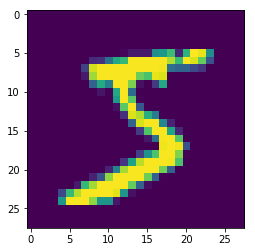

In [5]:
#training data shape
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
#visualize first example
plt.imshow(X_train[0])

In [0]:
#reshape the training and test data
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
#convert to 'float32' and divide by 255 to scale it in [0,1] i.e standarization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [8]:
#print the 1st 10 training examples
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [10]:
#one hot encoded data
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
#defining loss function reference- https://github.com/anubhavsatpathy/EVA/blob/master/Session5/EVA_S5.ipynb
def custom_loss(lambd, model, batch_size):
  
  def loss(y_true, y_pred):
    reg_loss = 0.0;
    for layer in model.layers:
      if layer.get_config()['name'].startswith('conv'):
        reg_loss += K.sum(K.square(layer.weights[0]))
    l2_loss = (lambd/(2*batch_size))*reg_loss
    return K.categorical_crossentropy(y_true,y_pred) + l2_loss
  
  
  return loss

### Model with BatchNormalization before ReLu, Dropout and LearningRateScheduler

Sometimes this is called learning rate annealing or adaptive learning rates. Here we will call this approach a learning rate schedule, were the default schedule is to use a constant learning rate to update network weights for each training epoch.

These have the benefit of making large changes at the beginning of the training procedure when larger learning rate values are used, and decreasing the learning rate such that a smaller rate and therefore smaller training updates are made to weights later in the training procedure.

This has the effect of quickly learning good weights early and fine tuning them later.

In [0]:
#model wih BatchNormalization, Dropout and LearningRateScheduler
def get_model():
  model = Sequential()

  model.add(Convolution2D(16, 3, 3,  input_shape=(28,28,1)))# RF=3
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(32, 3,3))#RF =5
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(MaxPooling2D((2,2)))#RF=10

  model.add(Convolution2D(10, 1))#RF=10
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(16, 3,3))#RF =12
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(32, 3,3))#RF =14
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(MaxPooling2D((2,2)))#RF=28

  model.add(Convolution2D(10, 1))#RF=28
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(10, 4))
  model.add(Flatten())
  model.add(Activation('softmax'))
  
  model.summary()
  return model

In [0]:
#define the scheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

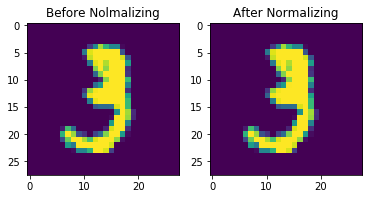

In [14]:
train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 5,
                                   )
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(X_train)
test_datagen.fit(X_test)

fig, ax = plt.subplots(1,2)
img = X_train[10]
ax[0].imshow(img.reshape(28,28))
ax[0].set_title("Before Nolmalizing")
train_datagen.standardize(img.reshape(1,28,28,1))
ax[1].imshow(img.reshape(28,28))
ax[1].set_title("After Normalizing")
plt.show()

train_data_iter = train_datagen.flow(X_train,Y_train, batch_size = 64)
test_data_iter =  test_datagen.flow(X_test,Y_test, batch_size = 10000)

In [15]:
model = get_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)       

In [16]:
#compile the model
lambd=0.01
model.compile(loss=custom_loss(lambd, model, 64), optimizer=Adam(lr=0.003), metrics=['accuracy'])

In [0]:
#checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,LearningRateScheduler(scheduler, verbose=1)]

In [18]:
history= model.fit_generator(train_data_iter, steps_per_epoch = 2000, epochs = 40, callbacks = callbacks_list, validation_data = test_data_iter.next(), verbose = 1)
  
print("Best Validation Accuracy : {}".format(np.max(history.history['val_acc'])))
  


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
2000/2000 [==============================] - 62s 31ms/step - loss: 0.1381 - acc: 0.9620 - val_loss: 0.0533 - val_acc: 0.9880

Epoch 00001: val_acc improved from -inf to 0.98800, saving model to best_model.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0698 - acc: 0.9833 - val_loss: 0.0487 - val_acc: 0.9908

Epoch 00002: val_acc improved from 0.98800 to 0.99080, saving model to best_model.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0617 - acc: 0.9863 - val_loss: 0.0444 - val_acc: 0.9912

Epoch 00003: val_acc improved from 0.99080 to 0.99120, saving model to best_model.hdf5
Epoch 4/40

Epoch 0

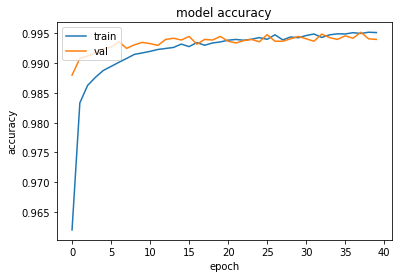

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model has achieved the target of 99.4% of validation accuracy in epoch 13.

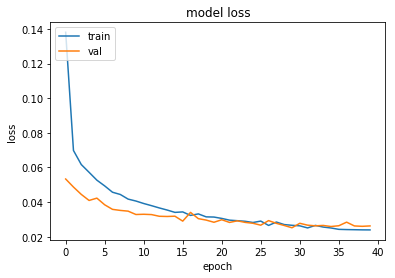

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Training and validation losses are comparable.

In [21]:
#load compile and predict.
model = get_model()
model.load_weights('best_model.hdf5')
model.compile(loss= 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

X_val,Y_val = test_data_iter.next()

Y_pred = model.predict(X_val)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 24, 24, 32)       

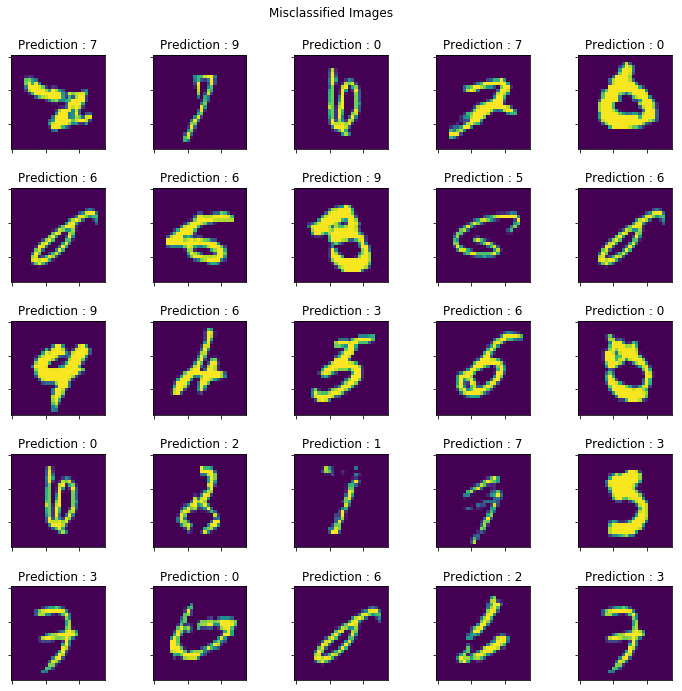

In [22]:
#Plot missclassified images.
misclassified_idx = []

for i in range(len(Y_val)):
  if np.argmax(Y_val[i])!= np.argmax(Y_pred[i]):
    misclassified_idx.append(i)

plt_idx = np.random.choice(misclassified_idx, 25)
fig, ax = plt.subplots(5,5,figsize = (10,10))
fig.tight_layout()
fig.suptitle('Misclassified Images')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
k = 0
for i in range(5):
  for j in range(5):
    img = X_val[plt_idx[k]].reshape(28,28)
    pred = np.argmax(Y_pred[plt_idx[k]])
    ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])
    ax[i,j].imshow(img)
    ax[i,j].set_title("Prediction : {}".format(pred))
    k += 1
